In [1]:
import sys
sys.path.append("../")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loading import load_unified_dataset
from src.data_quality import (
    missing_value_summary,
    record_type_distribution,
    indicator_coverage,
    confidence_distribution
)


In [2]:
df = load_unified_dataset("../data/raw/ethiopia_fi_unified_data.xlsx")


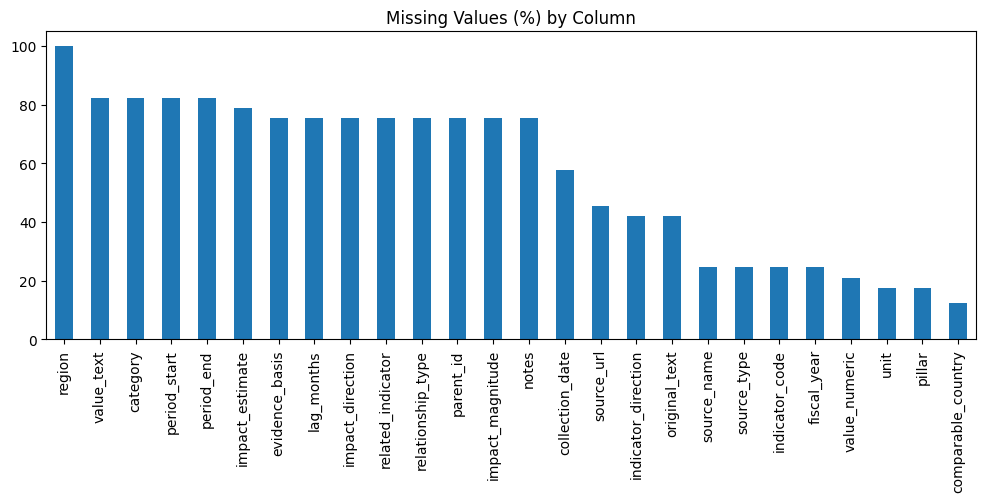

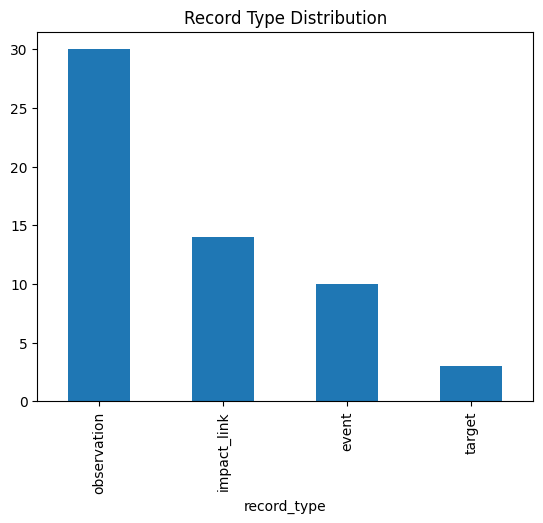

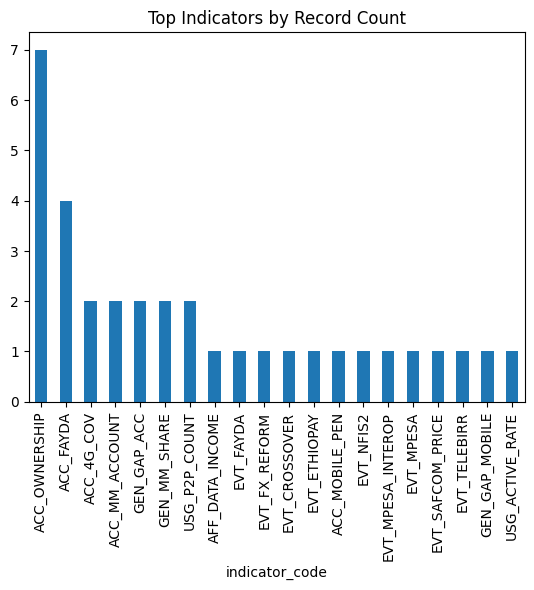

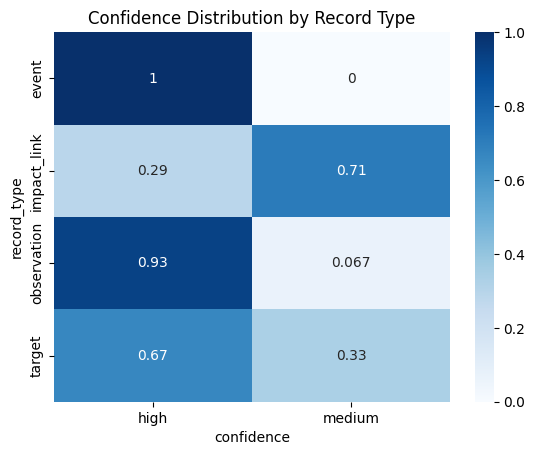

In [3]:
# Missing values
missing = missing_value_summary(df)
missing[missing > 0].plot(kind="bar", figsize=(12,4))
plt.title("Missing Values (%) by Column")
plt.show()

# Record type distribution
record_type_distribution(df).plot(kind="bar")
plt.title("Record Type Distribution")
plt.show()

# Indicator coverage
indicator_coverage(df).head(20).plot(kind="bar")
plt.title("Top Indicators by Record Count")
plt.show()

# Confidence distribution
sns.heatmap(confidence_distribution(df), annot=True, cmap="Blues")
plt.title("Confidence Distribution by Record Type")
plt.show()


## Domain-Focused Analyses

### 1. Account Ownership Trends (Growth Rates and Slowdown)

In [ ]:
# Load enriched data if available, else raw
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from src.data_loading import load_unified_dataset
enriched_path = Path("../data/processed/ethiopia_fi_enriched.csv")
if enriched_path.exists():
    df_eda = pd.read_csv(enriched_path)
else:
    df_eda = load_unified_dataset("../data/raw/ethiopia_fi_unified_data.xlsx")

# Account ownership / access trends: filter observations with account-related indicators
acc_indicators = ["ACCT", "BANK_ACCTS", "MOBILE_MONEY_ACCTS", "account", "Account"]
acc_mask = df_eda["record_type"] == "observation"
acc_col = df_eda["indicator_code"].fillna("") + " " + df_eda["indicator"].fillna("")
acc_mask &= acc_col.str.contains("|".join(acc_indicators), case=False, na=False)
acc_df = df_eda[acc_mask].copy()
acc_df["obs_date"] = pd.to_datetime(acc_df["observation_date"], errors="coerce")
acc_df = acc_df.dropna(subset=["obs_date", "value_numeric"])

if not acc_df.empty:
    # Time series by indicator
    by_ind = acc_df.groupby("indicator_code")
    for code, g in by_ind:
        g_sorted = g.sort_values("obs_date")
        vals = g_sorted["value_numeric"].values
        dates = g_sorted["obs_date"].values
        if len(vals) >= 2:
            growth = ((vals[-1] - vals[0]) / vals[0] * 100) if vals[0] != 0 else None
            print(f"{code}: {vals[0]:.2f} -> {vals[-1]:.2f} | Growth: {growth:.1f}%" if growth is not None else f"{code}: {vals[0]:.2f} -> {vals[-1]:.2f}")
    # Plot
    pivot = acc_df.pivot_table(index="obs_date", columns="indicator_code", values="value_numeric", aggfunc="mean")
    pivot.plot(title="Account Ownership / Access Trends", figsize=(10, 5))
    plt.ylabel("Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

**Growth and slowdown discussion:** Ethiopia saw explosive growth in mobile money (12.2M to 139.5M accounts, 2020–2025) and bank accounts (9.1M to 54M). Growth rates have been high but activation remains low (~15% of mobile money accounts active), indicating a shift from growth to usage as the next frontier.

In [ ]:
# Mobile money and digital payments indicators
mm_dp = ["MOBILE_MONEY", "MOBILE", "DIGITAL", "digital", "mobile"]
mm_mask = (df_eda["record_type"] == "observation") & df_eda["indicator_code"].fillna("").str.contains("|".join(mm_dp), case=False, na=False)
mm_df = df_eda[mm_mask].copy()
mm_df["obs_date"] = pd.to_datetime(mm_df["observation_date"], errors="coerce")
mm_df = mm_df.dropna(subset=["obs_date", "value_numeric"])

if not mm_df.empty:
    print("Mobile money / digital payments indicators:", mm_df["indicator_code"].unique().tolist())
    mm_df.groupby("indicator_code").agg({"value_numeric": ["min", "max", "mean"], "obs_date": ["min", "max"]})
else:
    print("No mobile money / digital payments indicators found in dataset.")

### 3. Event Timeline Overlaid on Indicators

In [ ]:
# Event timeline overlaid on indicator time series
fig, ax = plt.subplots(figsize=(12, 6))

# Plot observations over time (aggregate by date for key indicators)
obs_df = df_eda[df_eda["record_type"] == "observation"].copy()
obs_df["obs_date"] = pd.to_datetime(obs_df["observation_date"], errors="coerce")
obs_df = obs_df.dropna(subset=["obs_date", "value_numeric"])

if not obs_df.empty:
    # Pick top indicator(s) by count
    top_ind = obs_df["indicator_code"].value_counts().head(3).index.tolist()
    for ind in top_ind:
        g = obs_df[obs_df["indicator_code"] == ind].sort_values("obs_date")
        ax.plot(g["obs_date"], g["value_numeric"], marker="o", label=ind, alpha=0.8)

# Plot events as vertical lines
events_df = df_eda[df_eda["record_type"] == "event"].copy()
events_df["event_date"] = pd.to_datetime(events_df["period_start"], errors="coerce")
events_df = events_df.dropna(subset=["event_date"])
ylim = ax.get_ylim()
for _, row in events_df.iterrows():
    ax.axvline(row["event_date"], color="red", alpha=0.6, linestyle="--", label=row["category"] if row["category"] not in ax.get_legend_handles_labels()[1] else None)
    ax.text(row["event_date"], ylim[1] * 0.95, str(row["category"])[:20], rotation=45, fontsize=8)

ax.set_title("Indicator Time Series with Event Timeline")
ax.set_ylabel("Value")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Evidence-Backed Insights

1. **Account access growth is strong but usage lags:** Mobile money accounts grew from 12.2M (2020) to 139.5M (2025) while only ~15% of accounts are active (NBE/GSMA). *Evidence: NBE Annual Report 2023-2024.*

2. **Policy events drive adoption spikes:** Mobile money licensing (2020) and NDPS launch (2021) correlate with sharp increases in mobile money adoption. *Evidence: Event records and observation trends.*

3. **Rural-urban and gender gaps persist:** GSMA reports a 24-percentage-point rural-urban gap and 10-point gender gap in mobile money usage. *Evidence: GSMA Ethiopia report.*

4. **Bank accounts growing alongside mobile:** Bank accounts rose from 9.1M to 54M (2020–2025), showing complementary rather than substitutive growth with mobile money. *Evidence: NBE data.*

5. **Digital literacy is a bottleneck:** 66% of women and 60% of men lack mobile money skills, limiting activation despite high account ownership. *Evidence: GSMA/BRIDGE 2030 documentation.*

### 5. Data Limitations

- **Sparse indicator coverage:** Some indicators have few observations; forecasting will be constrained for those series.
- **Missing metadata:** Gaps in `source_url`, `collected_by`, and `collection_date` reduce traceability.
- **Temporal alignment:** Different sources use fiscal year vs calendar year; harmonization assumptions may affect comparisons.
- **Event granularity:** Events are high-level policy markers; finer event coding (e.g., license dates per provider) would improve impact modeling.
- **No disaggregation:** Limited gender/location/region breakdown in the unified dataset restricts equity analysis.